In [2]:
!pip install langgraph langsmith

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 14.1 MB/s eta 0:00:00


In [3]:
!pip install langchain langchain_groq langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [4]:
from langchain_groq import ChatGroq
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from IPython.display import Image, display

In [ ]:
groq_api_key = "your_api_key_here"
llm = ChatGroq(groq_api_key=groq_api_key, model_name="Gemma2-9b-It")

In [6]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    sentiment: str

# 1. Preprocessing Node
def preprocess(state: State) -> State:
    cleaned = state["messages"][-1].content.strip()
    state["messages"][-1].content = cleaned
    return state

# 2. Sentiment Analysis Node
def analyze_sentiment(state: State) -> State:
    msg = state["messages"][-1].content
    state["sentiment"] = "positive" if "good" in msg else "neutral"
    return state

# 3. Chatbot Node
def chatbot(state: State) -> State:
    return {"messages": llm.invoke(state['messages'])}

# 4. Logging Node
def logger(state: State) -> State:
    print(f"LOG: {state['messages'][-1].content}, Sentiment: {state.get('sentiment')}")
    return state

In [7]:
# Build the graph
builder = StateGraph(State)
builder.add_node("preprocess", preprocess)
builder.add_node("analyze_sentiment", analyze_sentiment)  # renamed
builder.add_node("chatbot", chatbot)
builder.add_node("logger", logger)

In [8]:
# Define flow
builder.add_edge(START, "preprocess")
builder.add_edge("preprocess", "analyze_sentiment")  # renamed
builder.add_edge("analyze_sentiment", "chatbot")     # renamed
builder.add_edge("chatbot", "logger")
builder.add_edge("logger", END)

In [9]:
graph = builder.compile()

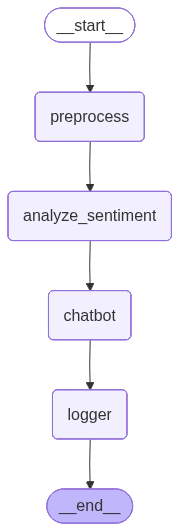

In [10]:
# Draw the graph
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [11]:
# Invoke the graph
input_message = "This is a good test message."
final_state = graph.invoke({"messages": ("user", input_message)})

# Print the final state
print("Final State:", final_state)
print("Chatbot's response:", final_state['messages'][-1].content)
print("Detected Sentiment:", final_state['sentiment'])

input_message_2 = "This is a neutral message."
final_state_2 = graph.invoke({"messages": ("user", input_message_2)})
print("Final State 2:", final_state_2)
print("Chatbot's response 2:", final_state_2['messages'][-1].content)
print("Detected Sentiment 2:", final_state_2['sentiment'])

LOG: I understand! Is there anything else I can help you with?  

Let me know if you want to:

* **Test my abilities further** with different types of questions or tasks.
* **Discuss a specific topic** you're interested in.
* **Just chat** and see what we can come up with!
, Sentiment: positive
Final State: {'messages': [HumanMessage(content='This is a good test message.', additional_kwargs={}, response_metadata={}, id='5e52edf2-f7b2-4f8a-a8bf-c6786261ded8'), AIMessage(content="I understand! Is there anything else I can help you with?  \n\nLet me know if you want to:\n\n* **Test my abilities further** with different types of questions or tasks.\n* **Discuss a specific topic** you're interested in.\n* **Just chat** and see what we can come up with!\n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 71, 'prompt_tokens': 16, 'total_tokens': 87, 'completion_time': 0.129090909, 'prompt_time': 0.00127902, 'queue_time': 0.018946439, 'total_time': 0.130369929}, '